<a href="https://colab.research.google.com/github/aishvellappally/Speech-Encoder/blob/master/Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from ast import literal_eval

In [0]:
import sys
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.2.0


In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, accuracy_score, recall_score
from sklearn.model_selection import train_test_split
import spacy 
from tensorflow.keras import initializers
from tensorflow.keras.models import Model,Sequential
import tensorflow.keras.layers
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import Dense, Input, Dropout, MaxPooling1D, Conv1D, Flatten, Activation
from tensorflow.keras.layers import Bidirectional, GRU, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
import tensorflow.keras.callbacks
import os

In [0]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
elif len(gpus) > 1: # multiple GPUs in one VM
    strategy = tf.distribute.MirroredStrategy(gpus)
    print('multi-gpu')
else: # default strategy that works on CPU and single GPU
    strategy = tf.distribute.get_strategy()
    print('cpu')

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.119.189.138:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.119.189.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.119.189.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [0]:
np.random.seed(42)

In [0]:
data = pd.read_excel('data_new.xlsx', delimiter = '\t')

In [0]:
data.head()

,path,actor,gender,emotion,valence,activation
0,speech_files/Ses01F_impro01/Ses01F_impro01_F00...,F01,F,neu,0,0
1,speech_files/Ses01M_impro03/Ses01M_impro03_F02...,F01,F,neu,2,1
2,speech_files/Ses01M_impro03/Ses01M_impro03_F02...,F01,F,exc,2,1
3,speech_files/Ses01M_impro03/Ses01M_impro03_F01...,F01,F,exc,2,2
4,speech_files/Ses01M_impro03/Ses01M_impro03_F01...,F01,F,neu,2,0


In [0]:
data = data.drop(['MFB', 'normalized'], axis=1)

In [0]:
data=data.drop(['Unnamed: 0'],axis=1)

In [0]:
data.replace(['low','mid','high'], [0,1,2], inplace = True)


In [0]:
for i in range(20):
  if (i == 0):
    feat1_df = pd.read_pickle('drive/My Drive/feature_files/feature_orig%s.pkl'%(i+1))
    result = feat1_df
  else:
    feat_df = pd.read_pickle('drive/My Drive/feature_files/feature_orig%s.pkl'%(i+1))
    frames = [result,feat_df]
    result = pd.concat(frames)

In [0]:
result.describe

<bound method NDFrame.describe of 0        [[0.00033833986, 0.00013587401, 2.0531057e-05,...
1        [[0.011469948, 0.015378022, 0.029045707, 0.003...
2        [[0.010275147, 0.07941946, 0.020318927, 0.0062...
3        [[0.0006920437, 0.0022492136, 0.0011821993, 0....
4        [[0.0019367585, 0.0015250507, 0.00030263982, 8...
                               ...                        
10034    [[0.0023372732, 0.00034015003, 4.03764e-05, 2....
10035    [[0.00050546747, 0.00029521994, 0.0001469691, ...
10036    [[0.0064669014, 0.0015277971, 0.0006420764, 0....
10037    [[0.0025848665, 0.0013115586, 0.0007592481, 0....
10038    [[0.010716233, 0.0026280445, 0.004199538, 0.00...
Name: MFB, Length: 10039, dtype: object>

In [0]:
data['features']=result

In [0]:
data.head()

,path,actor,gender,emotion,valence,activation,features
0,speech_files/Ses01F_impro01/Ses01F_impro01_F00...,F01,F,neu,0,0,"[[0.00033833986, 0.00013587401, 2.0531057e-05,..."
1,speech_files/Ses01M_impro03/Ses01M_impro03_F02...,F01,F,neu,2,1,"[[0.011469948, 0.015378022, 0.029045707, 0.003..."
2,speech_files/Ses01M_impro03/Ses01M_impro03_F02...,F01,F,exc,2,1,"[[0.010275147, 0.07941946, 0.020318927, 0.0062..."
3,speech_files/Ses01M_impro03/Ses01M_impro03_F01...,F01,F,exc,2,2,"[[0.0006920437, 0.0022492136, 0.0011821993, 0...."
4,speech_files/Ses01M_impro03/Ses01M_impro03_F01...,F01,F,neu,2,0,"[[0.0019367585, 0.0015250507, 0.00030263982, 8..."


In [0]:
# train _ val _ test split
actor_group = data.groupby('actor')

In [0]:
num_actors = actor_group.size()

In [0]:
num_actors

actor
F01     873
F02     859
F03    1048
F04     987
F05    1033
M01     946
M02     952
M03    1088
M04    1116
M05    1137
dtype: int64

In [0]:
#training for emotion classifier
df_train = data[0:3767]
df_train= df_train.append(data[4800:8902]) #training data has F01-F04, M01-M04

In [0]:
df_train = df_train.reset_index(drop = True)

In [0]:
df_train_shuff = shuffle(df_train, random_state=42)

In [0]:
df_train_shuff

,path,actor,gender,emotion,valence,activation,features
7794,speech_files/Ses04M_script02_1/Ses04M_script02...,M04,M,exc,1,0,"[[4.996508e-05, 9.925534e-05, 0.00020741053, 3..."
503,speech_files/Ses01M_script01_1/Ses01M_script01...,F01,F,ang,0,2,"[[0.022402408, 0.05171589, 0.003449829, 0.0059..."
6496,speech_files/Ses03M_impro05a/Ses03M_impro05a_M...,M03,M,xxx,0,2,"[[0.0012744386, 0.00063978403, 0.00023430413, ..."
5046,speech_files/Ses02M_impro03/Ses02M_impro03_M01...,M02,M,hap,2,2,"[[0.00022389139, 0.00086323667, 0.00044364342,..."
2298,speech_files/Ses03F_impro08/Ses03F_impro08_F02...,F03,F,neu,1,1,"[[1.9750947e-05, 4.2786047e-05, 3.9290302e-05,..."
...,...,...,...,...,...,...,...
5226,speech_files/Ses02M_script03_2/Ses02M_script03...,M02,M,fru,0,1,"[[0.00019274857, 0.00051902473, 0.00026156593,..."
5390,speech_files/Ses02M_script03_2/Ses02M_script03...,M02,M,fru,0,0,"[[0.0012090846, 0.018292079, 0.0060115145, 0.0..."
860,speech_files/Ses01F_script02_1/Ses01F_script02...,F01,F,hap,2,0,"[[0.00023642181, 0.0013219569, 0.006506602, 0...."
7603,speech_files/Ses04M_script02_1/Ses04M_script02...,M04,M,xxx,0,0,"[[0.00046033465, 0.0001907555, 0.00014631843, ..."


In [0]:
np.unique(df_train_shuff['actor'])

array(['F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M03', 'M04'],
      dtype=object)

In [0]:
X_train = df_train_shuff['features']
y1_train = df_train_shuff['valence']

In [0]:
X_train = X_train.to_numpy()

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [0]:
X_train[0]

array([[-0.02623276, -0.02607872, -0.02126434, ..., -0.01462094,
        -0.01472081, -0.01477564],
       [-0.02124226, -0.02528837, -0.02446065, ..., -0.01672508,
        -0.01680934, -0.01696464],
       [-0.01355734, -0.02132892, -0.02665111, ..., -0.00751508,
        -0.00750138, -0.00749504],
       ...,
       [-0.07252279, -0.01447601, -0.00268523, ..., -0.00141627,
        -0.00140561, -0.0013989 ],
       [-0.04708572, -0.01443674, -0.00221898, ..., -0.0012806 ,
        -0.00127166, -0.00126816],
       [-0.03291224, -0.01301061, -0.00263509, ..., -0.00091918,
        -0.00090958, -0.00091048]])

In [0]:
df_test = data[['features','valence']][8902:10039] #test set has M05
df_test = df_test.reset_index(drop=True)
df_test = shuffle(df_test, random_state =42)
X_test= df_test['features']
y1_test=df_test['valence']


In [0]:
X_test = X_test.to_numpy()

In [0]:
y1_test

787     0
903     0
289     2
1083    2
332     0
       ..
1044    0
1095    2
1130    0
860     1
1126    0
Name: valence, Length: 1137, dtype: int64

In [0]:
df_val = data[['features','valence']][3767:4800] #validation set has F05
df_val = df_val.reset_index(drop=True)
df_val=shuffle(df_val, random_state=42)
X_val = df_val['features']
y1_val = df_val['valence']
y1_val

294    0
453    2
636    2
139    2
538    0
      ..
87     2
330    0
466    0
121    1
860    2
Name: valence, Length: 1033, dtype: int64

In [0]:
X_val = X_val.to_numpy()

In [0]:
np.unique(data['actor'][3767:4800])

array(['F05'], dtype=object)

In [0]:
class_weights_val = {0: 1,
                1: 3.4,
                2: 1.9}
class_weights_act = {0: 1.2,
                1: 1.3,
                2: 1}               

In [0]:
num_classes = 3
def onehot(arr, num_class):
    return np.eye(num_class)[np.array(arr.astype(int)).reshape(-1)]

y1_train = onehot(y1_train, num_classes)
y1_test = onehot(y1_test, num_classes)
y1_val = onehot(y1_val, num_classes)

In [0]:
y1_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [0]:
y1_val

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [0]:
y1_test

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [0]:
X_val

array([array([[ 0.16402997, -0.2695424 ,  0.01268109, ..., -0.16402731,
        -0.18561003, -0.19890452],
       [ 0.00971331, -0.36207599, -0.30403992, ..., -0.00063711,
        -0.22234832, -0.28126085],
       [-0.02932763,  0.15023624, -0.26153386, ..., -0.07441207,
        -0.06020063, -0.33874527],
       ...,
       [-0.26220268, -0.26194294, -0.26401869, ..., -0.25484433,
        -0.25539139, -0.25931294],
       [-0.26218938, -0.26242416, -0.26413846, ..., -0.25509589,
        -0.25535502, -0.25913832],
       [-0.25995967, -0.26034942, -0.26194085, ..., -0.25329317,
        -0.25356814, -0.25753554]]),
       array([[ 0.15689507, -0.17972679, -0.48543388, ..., -0.03328354,
        -0.15412313, -0.34637862],
       [-0.07359037, -0.51767366, -0.48750263, ..., -0.13120751,
        -0.07303078, -0.21899575],
       [-0.71153698, -0.85893272, -0.3018456 , ..., -0.15359658,
        -0.35168574, -0.19486316],
       ...,
       [ 0.73249597,  0.74005499,  0.7984309 , ...,  0.66194

In [0]:
X1_train = np.zeros((X_train.shape[0],909,40))
for i in range(X_train.shape[0]):
  for j in range(909):
      X1_train[i][j][0:40]=X_train[i][j][0:40]

In [0]:
X1_val = np.zeros((X_val.shape[0],909,40))
for i in range(X_val.shape[0]):
  for j in range(909):
      X1_val[i][j][0:40]=X_val[i][j][0:40]

In [0]:
X1_test = np.zeros((X_test.shape[0],909,40))
for i in range(X_test.shape[0]):
  for j in range(909):
      X1_test[i][j][0:40]=X_test[i][j][0:40]

In [0]:
def create_model():
  nb_filter = [128,128,128,64,64]
  filter_length = [2,2,2,2,2]
  pool_length = 2
  in_frames = Input(shape=(448,40), dtype='float')
  
  embedded = Conv1D(filters=128,kernel_size=2,padding='same',activation='relu',kernel_initializer='glorot_normal',
                    strides=1)(in_frames)
  embedded = MaxPooling1D(pool_size=pool_length)(embedded)
  embedded = Dropout(0.2)(embedded)
  embedded = Conv1D(filters=128,kernel_size=2,padding='same',activation='relu',kernel_initializer='glorot_normal',
                    strides=1)(embedded)
  embedded = MaxPooling1D(pool_size=pool_length)(embedded)
  embedded = Dropout(0.2)(embedded)
  embedded = Conv1D(filters=128,kernel_size=2,padding='same',activation='relu',kernel_initializer='glorot_normal',
                    strides=1)(embedded)
  embedded = MaxPooling1D(pool_size=pool_length)(embedded)
  embedded = Dropout(0.2)(embedded)
  embedded = Conv1D(filters=128,kernel_size=2,padding='same',activation='relu',kernel_initializer='glorot_normal',
                    strides=1)(embedded)
  embedded = MaxPooling1D(pool_size=pool_length)(embedded)
  embedded = Dropout(0.2)(embedded)
  embedded = Conv1D(filters=128,kernel_size=2,padding='same',activation='relu',kernel_initializer='glorot_normal',
                    strides=1)(embedded)
  embedded = MaxPooling1D(pool_size=pool_length)(embedded)
  embedded = Dropout(0.2)(embedded)
    
   
  b_gru_1 = Bidirectional(GRU(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, implementation=0))(embedded)
  #b_gru_2 = Bidirectional(GRU(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, implementation=0))(b_gru_1)

  output = Dropout(0.2)(b_gru_1)
  output = Dense(3, activation='softmax')(output)

  model = Model(inputs=in_frames, outputs=output)

  model.summary()
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['ACCURACY',UAR])
  return model


In [0]:
from keras import backend as K
def UAR(y_true, y_pred):
  TP = [0,0,0]
  FN = [0,0,0]
  for i in range(y_true.shape[0]):
    if (y_true[i][0]==1):
      if (y_pred[i][0]>=0.5):
        TP[0]+=1
      else:
        FN[0]+=1
    elif (y_true[i][1]==1):
      if (y_pred[i][1]>=0.5):
        TP[1]+=1
      else:
        FN[1]+=1
    else:
      if (y_pred[i][2]>=0.5):
        TP[2]+=1
      else:
        FN[2]+=1
  R1 = TP[0]/(TP[0]+FN[0])
  R2 = TP[1]/(TP[1]+FN[1])
  R3 = TP[2]/(TP[2]+FN[2])
  avg_recall = 1/3* (R1+R2+R3)
  return R1, R2, R3, avg_recall

In [0]:
with strategy.scope():
  model = Sequential()
  model.add(Input(shape=(909,40),dtype='float'))
  model.add(Conv1D(128, 2, padding='causal',input_shape=(909,40), use_bias=True, kernel_initializer='lecun_normal',
                   kernel_regularizer = l2(1e-6)))
  model.add(BatchNormalization())
  model.add(Activation('selu'))
  model.add(MaxPooling1D(2))
  model.add(Conv1D(128, 2, padding='causal', use_bias=True, kernel_initializer='lecun_normal',
                   kernel_regularizer = l2(1e-6)))
  model.add(BatchNormalization())
  model.add(Activation('selu'))
  model.add(MaxPooling1D(2))
  model.add(Conv1D(64, 2, padding='causal', use_bias=True, kernel_initializer='lecun_normal',
                   kernel_regularizer = l2(1e-6)))
  model.add(BatchNormalization())
  model.add(Activation('selu'))
  model.add(MaxPooling1D(2))
  model.add(Conv1D(64, 2, padding='causal', use_bias=True, kernel_initializer='lecun_normal',
                   kernel_regularizer = l2(1e-6)))
  model.add(BatchNormalization())
  model.add(Activation('selu'))
  model.add(MaxPooling1D(2))
  model.add(Conv1D(64, 2, padding='causal', use_bias=True, kernel_initializer='lecun_normal',
                   kernel_regularizer = l2(1e-6)))
  model.add(BatchNormalization())
  model.add(Activation('selu'))
  model.add(MaxPooling1D(2))
  model.add(Bidirectional(GRU(64, return_sequences=True, recurrent_dropout=0.2, dropout = 0.2, implementation=2, 
                              use_bias=True,kernel_regularizer=l2(1e-6),recurrent_regularizer = l2(1e-6))))
  model.add(Bidirectional(GRU(64, return_sequences=True, recurrent_dropout=0.2, dropout = 0.2, implementation=2, 
                              use_bias=True,kernel_regularizer=l2(1e-6),recurrent_regularizer = l2(1e-6))))
  model.add(GlobalAveragePooling1D())
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(3))
  model.add(Activation('softmax'))
  opt = RMSprop(momentum=0.9)
  model.summary()
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 909, 128)          10368     
_________________________________________________________________
batch_normalization_24 (Batc (None, 909, 128)          512       
_________________________________________________________________
activation_24 (Activation)   (None, 909, 128)          0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 454, 128)          0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 454, 128)          32896     
_________________________________________________________________
batch_normalization_25 (Batc (None, 454, 128)          512       
_________________________________________________________________
activation_25 (Activation)   (None, 454, 128)         

In [0]:
EPOCHS=50
BATCH_SIZE = 128
rlop = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5)
checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#early = EarlyStopping(monitor='val_loss', mode='min')
callback = [checkpoint]
#10-fold cross validation

history = model.fit(X1_train, y1_train, epochs = EPOCHS, batch_size= BATCH_SIZE, validation_data=(X1_val, y1_val),verbose = 1,class_weight=class_weights_val, callbacks = [callback,rlop])

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 1.9267 - accuracy: 0.3617
Epoch 00001: val_loss improved from inf to 1.03992, saving model to model.h5
62/62 [==============================] - 12s 192ms/step - loss: 1.9267 - accuracy: 0.3617 - val_loss: 1.0399 - val_accuracy: 0.3814 - lr: 0.0010
Epoch 2/50
60/62 [============================>.] - ETA: 0s - loss: 1.8615 - accuracy: 0.3522
Epoch 00002: val_loss improved from 1.03992 to 0.93803, saving model to model.h5
62/62 [==============================] - 4s 67ms/step - loss: 1.8631 - accuracy: 0.3535 - val_loss: 0.9380 - val_accuracy: 0.5924 - lr: 0.0010
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 1.8357 - accuracy: 0.3473
Epoch 00003: val_loss did not improve from 0.93803
62/62 [==============================] - 4s 60ms/step - loss: 1.8357 - accuracy: 0.3473 - val_loss: 1.0306 - val_accuracy: 0.5779 - lr: 0.0010
Epoch 4/50
61/62 [============================>.] - ETA: 0s - loss: 1.8399 - a

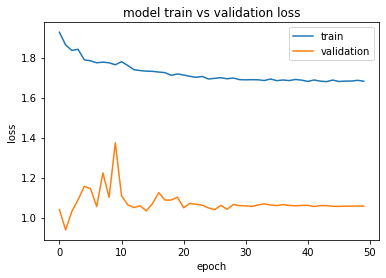

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [0]:
predictions = model.predict(X1_test, batch_size = 128, verbose = 1)

9/9 [==============================] - 1s 99ms/step


In [0]:
predictions.shape

(1144, 3)

In [0]:
y1_test.shape

(1137, 3)

In [0]:
R1, R2, R3, recall = UAR(y1_test, predictions)

In [0]:
recall

0.07159524105496509

In [0]:
R1

0.1875

In [0]:
R2

0.005780346820809248

In [0]:
R3

0.021505376344086023